# Import Dataset

## **Import Modules**

In [148]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join

## **Load OPPORTUNITY Dataset**

In [149]:
mypath = 'Dataset/OpportunityDataset/dataset'
basepath = ''

files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and f[-3:]=='dat' and f[-9:-4]!='Drill']
files = sorted(files)
files = [join(mypath,f) for f in files]

In [150]:
def load_data(filename):
  g = 9.8
  xyz_cols = ['x','y','z']
  using_cols = [0,23,24,25,243]
  
  df = pd.read_csv(filename, sep='\s+', usecols=using_cols,names=['ts','x','y','z','label'], header=None, engine='python')

  df = df.dropna(axis='index')
  df[xyz_cols] = df[xyz_cols].apply(lambda x: x/1000 * g)
  
  return df

In [151]:
df1 = load_data(files[0])
df2 = load_data(files[1])
df3 = load_data(files[2])

In [152]:
df1['label'].value_counts()

1    22168
0    12951
4     7437
2     6465
5     1128
Name: label, dtype: int64

In [153]:
# df2['label'].value_counts()

1    10268
0     6686
2     6512
4     6314
5     1365
Name: label, dtype: int64

In [154]:
# df3['label'].value_counts()

1    9958
4    7544
0    6683
2    5950
5    1294
Name: label, dtype: int64

# Preprocess Data

## **Import sklearn Library**

In [155]:
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

## **Prepare Data**

In [156]:
def normalize_data(series):
  series = np.array(series)
  
  scaler = MinMaxScaler(feature_range=(0, 1))
  scaler = scaler.fit(series)
  
  return scaler.transform(series)

In [157]:
def prepare_data(df1):
  feature_cols = ['x','y','z']
  label_cols = ['label']

  X_series = df1[feature_cols]
  y_series = df1[label_cols]

  X_train = normalize_data(X_series)
  # Convert labels to a binary vector
  y_train = label_binarize(y_series.values, classes=[0,1,2,3,4,5])

  length = len(X_train)

  X_train = X_train.reshape((length,1,TRIAXIAL))
  y_train = y_train.reshape((length,1,LABEL_COUNT))
  
  return X_train, y_train

In [158]:
# define parameters
LABEL_COUNT = 6
TRIAXIAL = 3

In [159]:
# Load data from a certain dataframe
X_train, y_train = prepare_data(df1)
X_val, y_val = prepare_data(df2)
X_test, y_test = prepare_data(df3)

In [160]:
VALIDAT_LEN = len(X_val)
print(VALIDAT_LEN)

X_train_1 = X_train[:VALIDAT_LEN]
y_train_1 = y_train[:VALIDAT_LEN]

X_test = X_test[:VALIDAT_LEN]
y_test = y_test[:VALIDAT_LEN]

31145


In [161]:
TESTING_LEN = len(X_test)
# TRAINING_LEN = len(X_train)

print(X_train_1.shape, X_val.shape, X_test.shape)
print(y_train_1.shape, y_val.shape, y_test.shape)

print()
print(VALIDAT_LEN, TESTING_LEN)
print()

print(X_test[0])
print(y_test[0])

(31145, 1, 3) (31145, 1, 3) (31145, 1, 3)
(31145, 1, 6) (31145, 1, 6) (31145, 1, 6)

31145 31145

[[0.66 0.56 0.56]]
[[1 0 0 0 0 0]]


In [162]:
LABELS = [0,1,2,4,5]

d1 = y_val
# print(len(d1))
print(d1[1600][0],'\n')
  
cnter = [0,0,0,0,0,0]

for x in range(len(d1)):
  for a in range(len(d1[0])):
    for lb in LABELS:
      if d1[x][0][a]==1 and a==lb:
        cnter[a] += 1
        
print(cnter)

[0 1 0 0 0 0] 

[6686, 0, 0, 0, 0, 0]


 # Classification

## Import keras library

In [163]:
import keras

from keras import metrics
from keras import callbacks
from keras import models

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import GRU, Input, concatenate
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

## **Create RNN Model**

In [272]:
def create_rnn_model():
  model = Sequential()
  
  # RNN layers
  gru_layer_1 = GRU(units=GRU_UNITS, 
#                  dropout=0.1, recurrent_dropout=0.1, 
                 return_sequences=True,
                 input_shape=(X_val.shape[1], X_val.shape[2]))
  
  model.add(gru_layer_1)
  model.add(Activation('relu'))
  
  gru_layer_2 = GRU(units=GRU_UNITS_2, 
#                  dropout=0.1, recurrent_dropout=0.1, 
                 return_sequences=True)

  model.add(gru_layer_2)
  model.add(Activation('relu'))
  
  # Output layers
  output = Dense(LABEL_COUNT, activation='softmax')
  drpout = Dropout(0.08, seed=42)
  model.add(output)
  model.add(drpout)
  
  return model

In [273]:
# define GRU units
GRU_UNITS = 90
GRU_UNITS_2 = 90

rnn_model = create_rnn_model()
rnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_35 (GRU)                 (None, 1, 90)             25380     
_________________________________________________________________
activation_35 (Activation)   (None, 1, 90)             0         
_________________________________________________________________
gru_36 (GRU)                 (None, 1, 90)             48870     
_________________________________________________________________
activation_36 (Activation)   (None, 1, 90)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 1, 6)              546       
_________________________________________________________________
dropout_16 (Dropout)         (None, 1, 6)              0         
Total params: 74,796
Trainable params: 74,796
Non-trainable params: 0
_________________________________________________________________


In [274]:
initial_lrate = 0.001

optimizer = keras.optimizers.Adam(lr=initial_lrate)

rnn_model.compile(optimizer=optimizer,
                  loss=keras.losses.categorical_crossentropy,
                  metrics=[metrics.categorical_accuracy])

## Train the Model

In [275]:
drop = 0.9
epochs_drop = 9.0

decay_rate = []

In [276]:
def scheduler(epoch):
  lrate = initial_lrate * math.pow(drop, math.floor((epoch)/epochs_drop))
  decay_rate.append(lrate)
  
  return lrate

In [277]:
chkpoint_path = basepath + 'model_chkpoints/weights.best.hdf5'

model_chkpoint = ModelCheckpoint(chkpoint_path, verbose=0, save_best_only=True, save_weights_only=True)
early_stop = EarlyStopping(monitor='categorical_accuracy', min_delta=0.1, patience=10, verbose=0)
lrate = LearningRateScheduler(scheduler, verbose=1)

In [278]:
BATCH_SIZE = 50
EPOCHS = 50

In [279]:
model_fit = rnn_model.fit(X_train_1, y_train_1,
                 batch_size=BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(X_val, y_val),
                 verbose=1,
                 callbacks=[model_chkpoint, early_stop, lrate])

Train on 31145 samples, validate on 31145 samples
Epoch 1/50

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
31145/31145 [==============================] - 11s 353us/step - loss: 2.2628 - categorical_accuracy: 0.4940 - val_loss: 1.6277 - val_categorical_accuracy: 0.3395
Epoch 2/50

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
31145/31145 [==============================] - 7s 217us/step - loss: 2.1453 - categorical_accuracy: 0.5434 - val_loss: 1.3878 - val_categorical_accuracy: 0.3291
Epoch 3/50

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
31145/31145 [==============================] - 7s 210us/step - loss: 2.1493 - categorical_accuracy: 0.5526 - val_loss: 1.3285 - val_categorical_accuracy: 0.3701
Epoch 4/50

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
31145/31145 [==============================] - 7s 211us/step - loss: 2.0543 - categorical_accuracy: 0.5777 - val_loss: 1.2953 - val_categorical_accura

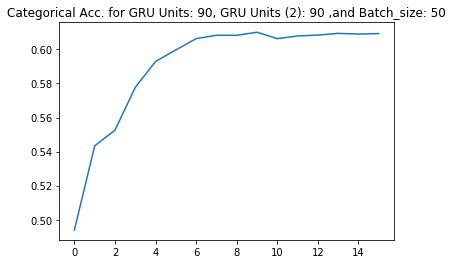

In [280]:
plt.plot(model_fit.history['categorical_accuracy'])
plt.title('Categorical Acc. for GRU Units: ' + str(GRU_UNITS) + ', GRU Units (2): ' + str(GRU_UNITS_2) + ' ,and Batch_size: ' + str(BATCH_SIZE))

plt.savefig(basepath + 'Graphs/RNN_accuracy_' + str(GRU_UNITS) + '_' + str(GRU_UNITS_2) + '_' + str(BATCH_SIZE) + '.png', dpi=200)
plt.show()

## Evaluate the Model

In [281]:
rnn_model.load_weights(chkpoint_path)

In [282]:
y_pred = rnn_model.predict(X_test, batch_size=BATCH_SIZE)

In [283]:
y_pred

array([[[4.93e-01, 3.99e-01, 1.05e-01, 1.22e-05, 1.44e-03, 1.72e-03]],

       [[5.22e-01, 3.74e-01, 1.01e-01, 1.22e-05, 1.15e-03, 2.05e-03]],

       [[4.97e-01, 4.02e-01, 9.82e-02, 1.03e-05, 1.04e-03, 1.60e-03]],

       ...,

       [[7.16e-01, 1.81e-01, 8.50e-02, 3.09e-05, 7.01e-04, 1.72e-02]],

       [[7.42e-01, 1.62e-01, 8.00e-02, 2.53e-05, 5.50e-04, 1.52e-02]],

       [[6.95e-01, 1.92e-01, 9.13e-02, 4.03e-05, 9.89e-04, 2.11e-02]]],
      dtype=float32)

In [284]:
# get the max probability for label binarized y value
def convert_y(y):
  y_conv = [j for i in range(len(y)) for j in range(len(y[i][0])) if y[i][0][j]==np.amax(y[i][0])]
  return np.array(y_conv)

In [285]:
print(convert_y(y_test))
print(convert_y(y_pred))

[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]


In [286]:
y_t = convert_y(y_test)
y_p = convert_y(y_pred)
      
print("GRU units: ", GRU_UNITS)
print('GRU units 2: ', GRU_UNITS_2)
print("Batch size: ", BATCH_SIZE)
print()
  
score = confusion_matrix(y_t, y_p, labels=[0,1,2,4,5])
acc_score = accuracy_score(y_t, y_p)

print("Accuracy: ", acc_score)
print("Confusion matrix: \n" , score)

GRU units:  90
GRU units 2:  90
Batch size:  50

Accuracy:  0.41785198266174345
Confusion matrix: 
 [[3184 2920    0  216   79]
 [2097 7766    0   44   51]
 [2136 3716    0   67   31]
 [ 144 5892    0 1508    0]
 [   6  732    0    0  556]]


## Confusion Matrix

In [287]:
%run eval_score.ipynb

In [288]:
LABELS = ['Nan','Stand','Walk','Sit','Sleep']

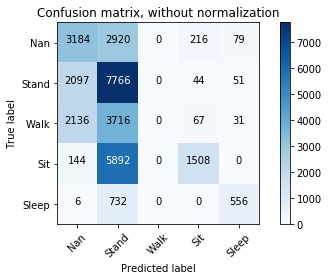

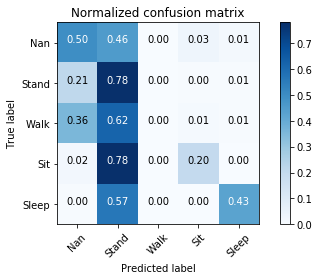

In [289]:
show_conf_matrix(y_t, y_p, LABELS)

In [290]:
show_clf_report(y_t, y_p, LABELS)

             precision    recall  f1-score   support

        Nan       0.42      0.50      0.46      6399
      Stand       0.37      0.78      0.50      9958
       Walk       0.00      0.00      0.00      5950
        Sit       0.82      0.20      0.32      7544
      Sleep       0.78      0.43      0.55      1294

avg / total       0.44      0.42      0.35     31145



E:\ProgramData\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Note (1)
* **0 - NaN**
* **1 - Stand**
* **2 - Walk**
* **4 - Sit**
* **5 - Lie**

### Note (2)

* **GRU units = 150, GRU units (2) = 150, Batch_size = 80,  acc = 0.4164**

* **GRU units = 180, GRU units (2) = 150, Batch_size = 80,  acc = 0.4257**

* **GRU units = 180, GRU units (2) = 180, Batch_size = 80,  acc = 0.4284**

* **GRU units = 200, GRU units (2) = 200, Batch_size = 80,  acc = 0.4158**

* **GRU units = 190, GRU units (2) = 190, Batch_size = 80,  acc = 0.4253**

* **GRU units = 180, GRU units (2) = 180, Batch_size = 70,  acc = 0.4356**

* **GRU units = 180, GRU units (2) = 180, Batch_size = 50,  acc = 0.4423**

* **GRU units = 180, GRU units (2) = 180, Batch_size = 10,  acc = 0.4361**

* **GRU units = 180, GRU units (2) = 180, Batch_size = 100,  acc = 0.4013**

* **GRU units = 90, GRU units (2) = 90, Batch_size = 50,  acc = 0.4428**     <---------  Maximum so far :-(

* **GRU units = 60, GRU units (2) = 60, Batch_size = 50,  acc = 0.4258**

* **GRU units = 60, GRU units (2) = 60, Batch_size = 50,  acc = 0.4028**